# Preamble

In [1]:
#provides functions for generating noise
!pip install allantools

In [2]:
#numerical libraries for working with noise arrays
import numpy as np
import pandas as pd
#plotting custom plots
import matplotlib.pyplot as plt
#calculate the overlapping Allan deviation
from allan_variance import overlapping_allan_deviation, plot_allan_deviation, demo_logged_single_axis_gyroscope

# Summarize Logged Single Axis Gyroscope Data

In [3]:
#upload csv before running
path = "/content/LoggedSingleAxisGyroscope.csv"
df = pd.read_csv(path)
df.columns = ["Data"]

Logged Single Axis Gyroscope data is instantaneous rate calculated by the gyroscope of an inertial measurement unit (IMU).

During the measurement experiment that collected this data, the gyroscope is meant to be stationary (not moving).

Experimenters collected this data at a rate of 100 Hz.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159999 entries, 0 to 2159998
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Data    float64
dtypes: float64(1)
memory usage: 16.5 MB


The values are using 64 bits of precision. This is an important metric to note to avoid quantization error.

In [5]:
df.describe()

,Data
count,2.159999e+06
mean,1.193918e-01
std,1.223136e-01
min,-2.240000e+00
25%,6.125000e-02
50%,1.225000e-01
75%,1.750000e-01
max,2.231300e+00


- There are about 2 million rows
- The average and standard deviation are both about 0.1

An ideal stationary gyroscope would have mean 0 and standard deviation 0 (indicating that the device is completely stationary!). However, noise sources introduce error in the readings.

Advances in IMU technology can reduce noise, but it is always present. So, it is useful to quantify the best possible performance of the device. This is done by first quantifying the contribution of all the noise sources to the error. The Allan deviation can be used to do exactly this calculation.

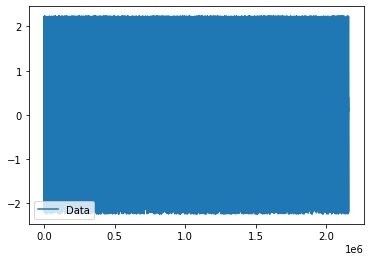

In [6]:
df.plot()

The above plot is a time series of the readings gathered by the IMU computer communicating with the gyroscope.

What we can take from this plot is that over the course of the measurement experiment (remember, the gyroscope sta completely stationary for the entire experiment) the instantaneous angle measured by the gyroscope hovered around 0 and spread $\pm$2 **LOOK UP UNITS AGAIN** around that value.

Depending on the application, we might consider this "stable enough". 
___
How long did the experiment run for?  
    - Know there are 2159999 points  
    - Know the sampling rate is 100 Hz (one sample every 0.01 seconds)

In [7]:
(2159999*0.01)/(3600)

5.999997222222222

What a boring experiment! The gyroscope sat perfectly still while **data was collected for about 6 hours**

# Allan Deviation

Let's look at the Allan deviation of the data. 

Think of the Allan deviation of a signal as a fingerprint. The shape and magnitude of the plot gives information about the error that makes up the signal.

That is, if we (mathematically) model a real-world IMU as:  
$\Omega(t)=\Omega_{Ideal}+Noise$  
Then the Allan deviation estimates the $Noise$ term for us.  

Below is the Allan deviation of the gyroscope data.

File saved at
/content/Logged Single Axis Gyro.png
CPU times: user 3.78 s, sys: 100 ms, total: 3.88 s
Wall time: 3.88 s


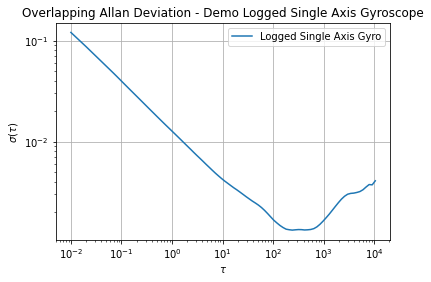

In [8]:
%%time 
demo_logged_single_axis_gyroscope()

An inertial navigation expert would be able to learn a lot about the error characteristics of this specific gyroscope.

We are not quite there, yet.

# SMAC IMU Data

To prove that the Allan variance algorithm works, we try to plot the Allan deviation of some [data from the SMAC Group](https://github.com/SMAC-Group/imudata). The idea is that this data was collected independently of this research project. So, we have a little more confidence that the algorithm is not biased toward MATLAB generated data or the Lia, 2017 data in some way.

In [9]:
#data_path = "/content/LoggedSingleAxisGyroscope.csv"
smac_path = "/content/drive/MyDrive/Colab Notebooks/IMU Error Research/Datasets/imu6.csv"
reader = pd.read_csv(smac_path)
reader.head()

,Unnamed: 0,Gyro. X,Gyro. Y,Gyro. Z,Accel. X,Accel. Y,Accel. Z
0,1,-0.011138,-0.017646,-0.009531,1.083731,0.023897,9.638113
1,2,-0.006765,-0.013657,-0.021974,1.059858,0.042061,9.646901
2,3,-0.002779,-0.010913,-0.024058,1.060207,0.023655,9.665417
3,4,-0.006934,-0.021248,-0.018351,1.059921,0.027322,9.633001
4,5,-0.008164,-0.015213,-0.026140,1.069064,0.032950,9.643449


In [10]:
#only looking at the gyro columns
gyroDF = reader[["Gyro. X", "Gyro. Y", "Gyro. Z"]]

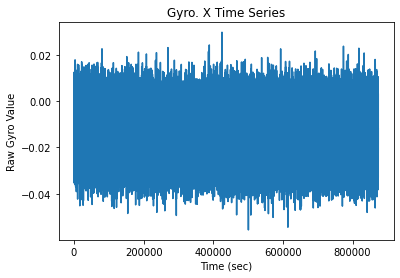

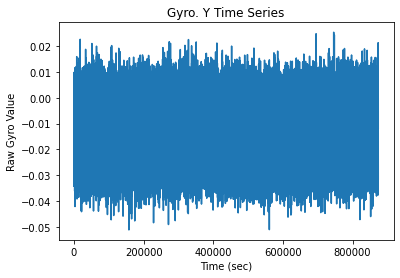

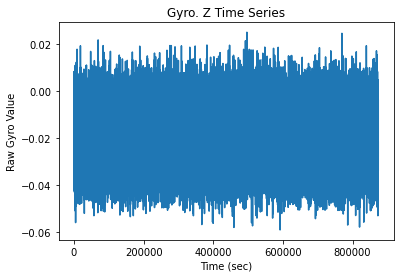

In [11]:
#plot the data as time series
for column in gyroDF:
    x = np.arange(len(gyroDF[column]))
    plt.plot(x, gyroDF[column])
    
    plt.title(f"{column} Time Series")
    plt.xlabel("Time (sec)")
    plt.ylabel("Raw Gyro Value")

    plt.show()


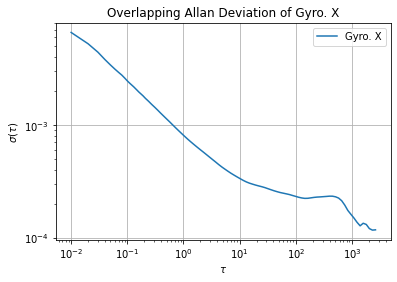

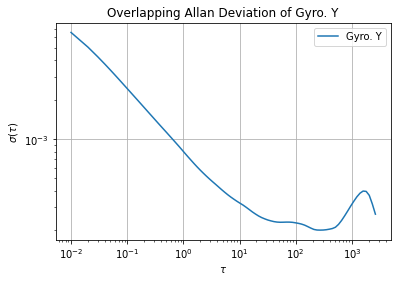

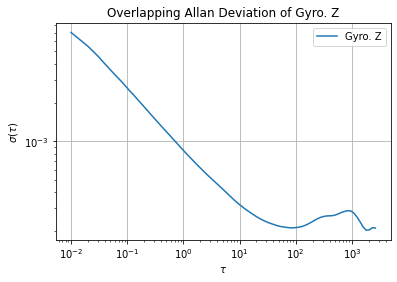

In [12]:
#calculate values for ADEV
sampling_rate = 100 #Hz
for column in gyroDF:
    omega = gyroDF[column].to_numpy()
    taus, oadev = overlapping_allan_deviation(omega, sampling_rate)
    plot_allan_deviation(taus, oadev, label=f"{column}", title=f"Overlapping Allan Deviation of {column}")

Now that we've seen the algorithm in action, let's try to understand it a little more with an example.

We'll build up simulated data with known, controlled statistical properites and explore what happens to the resulting ADEV plot. 

# A simulated example

In [13]:
#number of points in the signal
num_points = 2_500_000

#let's use the same sampling rate as before
Fs = 100 #Hz

Now, when we create the simulated gyroscope signal it will be as if data was collected for ~6 hours

In [14]:
ideal_stationary = np.zeros((num_points,))

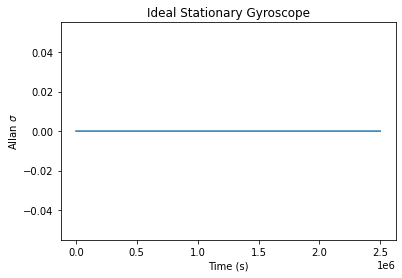

In [15]:
plt.plot(ideal_stationary)
plt.title("Ideal Stationary Gyroscope")

plt.xlabel("Time (s)")
plt.ylabel("Allan $\sigma$")
plt.show()
plt.close()

In [16]:
def normalize(data, smin, smax, a, b):
    return np.array([((b-a)*(x-smin)/(smax-smin))+a for x in data])

## White Noise
Next, pollute the ideal signal with white noise

In [17]:
import allantools

In [18]:
white_noise = allantools.noise.white(num_points=num_points)

At this point, it helps to see the white noise series characteristics

In [19]:
#sequence summary statistics
white_summary = pd.DataFrame({"White Noise":white_noise}).describe().transpose()

In [20]:
display(white_summary)

,count,mean,std,min,25%,50%,75%,max
White Noise,2500000.0,-0.000099,0.707023,-3.430751,-0.477113,-0.000218,0.476298,3.664217


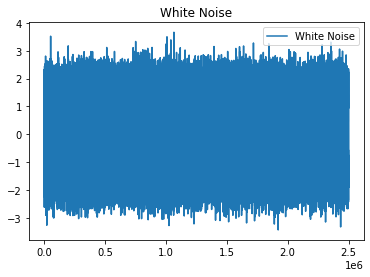

In [21]:
plt.plot(white_noise, label="White Noise")

plt.title("White Noise")
plt.legend(loc="upper right")
plt.show()
plt.close()

The spread is about the same as our real data, but without seeding running this notebook again would change the exact results. That's alright, as long as we scale our sequences to match what we want.

In this case, I'm satisfied. So, future sequences will need to be scaled (assuming we want every noise source to contribute about equally) to match the min/max presented here.

Let's squish down the white noise to be between -2 and 2

In [22]:
white_noise = normalize(white_noise, np.min(white_noise), np.max(white_noise), -2, 2)

,count,mean,std,min,25%,50%,75%,max
White Noise,2500000.0,-0.065868,0.398605,-2.0,-0.334799,-0.065935,0.202715,2.0


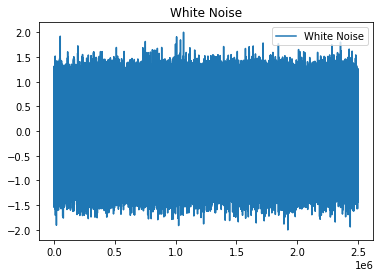

In [23]:
white_summary = pd.DataFrame({"White Noise":white_noise}).describe().transpose()
display(white_summary)
plt.plot(white_noise, label="White Noise")

plt.title("White Noise")
plt.legend(loc="upper right")
plt.show()
plt.close()

Note:  The data is only about half as spread out as before, since the standard deviation is about half as large.

In [24]:
#we will continue to add noise to this array
#for now, just add white noise
noisy_signal = ideal_stationary + white_noise

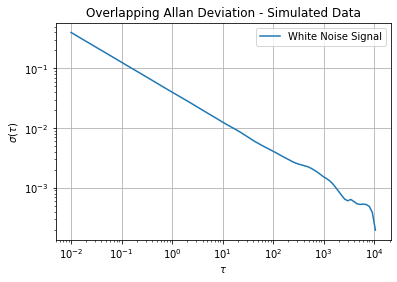

In [25]:
taus, oadev = overlapping_allan_deviation(noisy_signal, Fs=Fs)
plot_allan_deviation(taus, oadev, label="White Noise Signal", title="Overlapping Allan Deviation - Simulated Data", savefig=False)

The Allan deviation plot above does not look like the one we saw for our stationary gyroscope. For the most part, the above plot is a straight line. 

What's the slope of the straight part?

In [26]:
def loglog_straight_line(taus, intercept, slope):
    """Helper function that plots a power law with specified parameters.
    On a log-log scale, any power law (y=bx**m) is a straight line with
    intercept:  log(b)
    slope: m
    """
    return np.power(np.multiply(intercept, taus), slope)

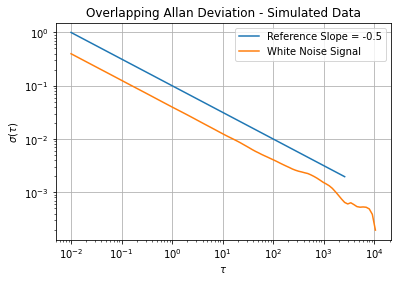

In [27]:
slope_minus_half = loglog_straight_line(taus=taus[:int(len(taus)*.90)], intercept=100, slope=-0.5)
plt.loglog(taus[:int(len(taus)*.90)], slope_minus_half, label="Reference Slope = -0.5")
plot_allan_deviation(taus, oadev, label="White Noise Signal", title="Overlapping Allan Deviation - Simulated Data", savefig=False)

Qualitatively, we can say that the slope of the Allan deviation plot from $\\tau\in(10^{-2}, 10^{3})$ is -0.5.

According to **INSERT REFERENCE HERE**, a slope of -0.5 indicates white noise in our signal. The Allan deviation plot is saying that if we average over the times scales in this region of $\\tau$, then we can correct for this quickly oscillating noise.

## Pink Noise

I want to have control over where the signal meets the criteria for $\nabla=0$. I thought that one approach might be to add pink noise only to a portion of the signal (a small region [a, b] of the domain). 

The function below will mix the existing signal and pink noise for only the percentage of the time domain specified by the function.

Example:  Add pink noise to only the last 50% of the provided signal
```
#50% of the values are 0; 50% are samples of pink noise
pink_noise = position_noise(make_pink_noise, my_signal, 0.5, 1.0):

noisy_signal = my_signal + pink_noise
```

In [28]:
def position_noise(noise_func, signal, start, stop):
    """
    Position a noise signal in the desired time region of a signal, but nowhere else

    Args:
    noise_func (function):  Function to create noise. Preferrably from `allantools`.
                            Should accept number of points to draw.
    signal (numpy array):  Phase data to add noise to
    start (float):  A percent of how deep into the time axis to begin drawing noise.
    stop (float):  A peprceont of how deep into the time axis to stop drawing noise.
    """
    
    #sanitize `start` and `stop`
    assert type(start)==float and type(stop)==float
    assert (start >=0) and (stop >=0)
    assert stop >= start


    #calculate the region to substitute with noise
    total_pts = len(signal)
    start_idx = int(start*total_pts)
    stop_idx = int(stop*total_pts)
    len_region = abs(stop_idx-start_idx)

    #draw noise samples
    noise = noise_func(len_region)

    #construct the noisy signal
    result = np.zeros_like(signal)
    result[start_idx:stop_idx] = noise
    
    return result

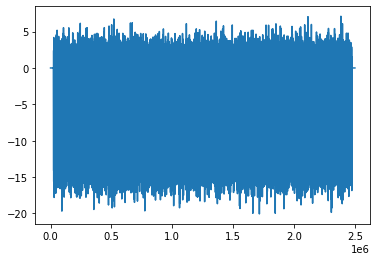

In [29]:
#define some range where pink noise happens
pink_noise = position_noise(allantools.noise.pink, ideal_stationary, 0.01, 0.99)
plt.plot(pink_noise)

In [30]:
pink_noise = normalize(pink_noise, np.min(pink_noise), np.max(pink_noise), -2, 2)

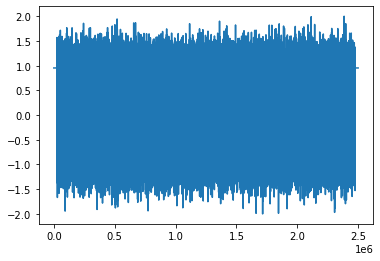

In [31]:
plt.plot(pink_noise)

In [32]:
#actually add the pink noise
noisy_signal += pink_noise

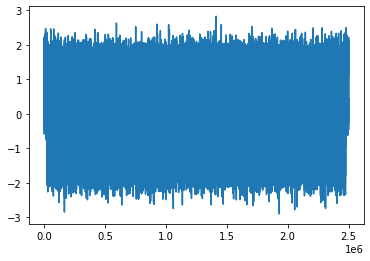

In [33]:
#plot the signal time series
plt.plot(noisy_signal)

In [34]:
#calculate the allan dev
(taus, oadev) = overlapping_allan_deviation(omega=noisy_signal, Fs=Fs)

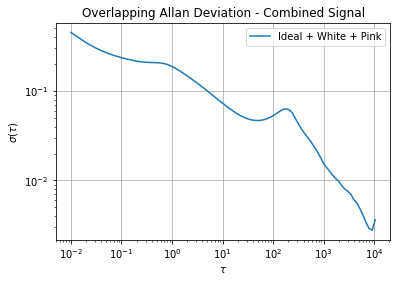

In [35]:
#plot the allan dev
plot_allan_deviation(taus=taus, sigmas=oadev, label="Ideal + White + Pink", title="Overlapping Allan Deviation - Combined Signal")

## Shrinking the Region Raw Pink Noise is Added

In [36]:
def shrinking_pink_noise_region(signal, regions):    

    for i in regions:
        pink_noise = position_noise(allantools.noise.pink, signal, i[0], i[1])
        cand = signal+pink_noise 
        taus, oadev = overlapping_allan_deviation(cand, Fs=100)
        plot_allan_deviation(taus, oadev, "{:.2f}:{:.2f}".format(i[0], i[1]), "Shrinking Pink Noise Region")

    return 

In [37]:
left = np.arange(0, 0.525, 0.025)
regions = [(float(x), float(1-x)) for x in left]
regions

[(0.0, 1.0),
 (0.025, 0.975),
 (0.05, 0.95),
 (0.07500000000000001, 0.925),
 (0.1, 0.9),
 (0.125, 0.875),
 (0.15000000000000002, 0.85),
 (0.17500000000000002, 0.825),
 (0.2, 0.8),
 (0.225, 0.775),
 (0.25, 0.75),
 (0.275, 0.725),
 (0.30000000000000004, 0.7),
 (0.325, 0.675),
 (0.35000000000000003, 0.6499999999999999),
 (0.375, 0.625),
 (0.4, 0.6),
 (0.42500000000000004, 0.575),
 (0.45, 0.55),
 (0.47500000000000003, 0.5249999999999999),
 (0.5, 0.5)]

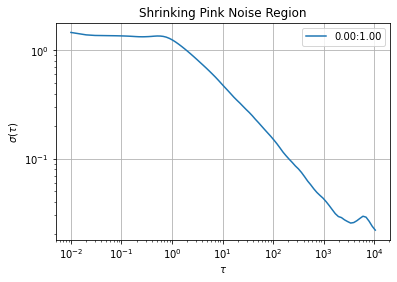

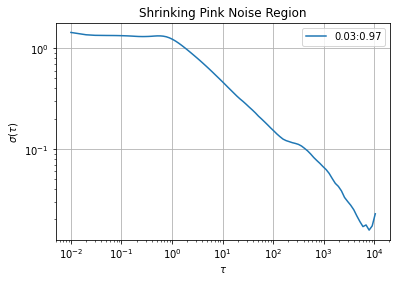

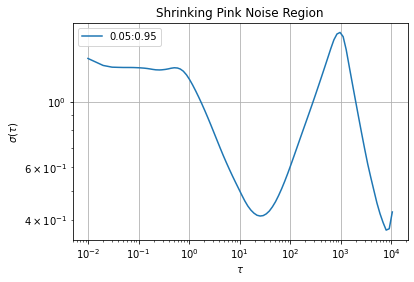

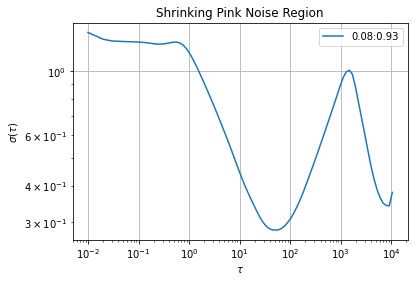

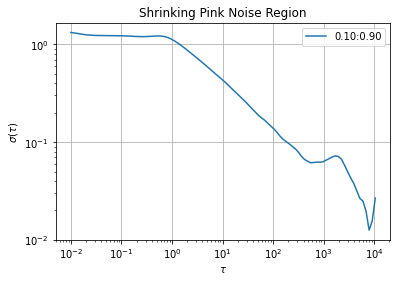

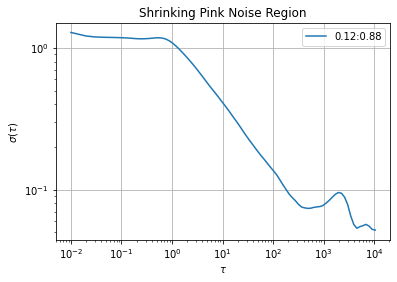

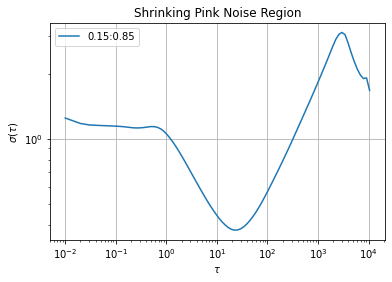

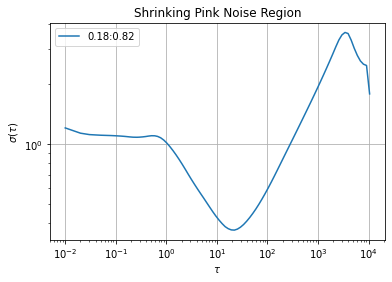

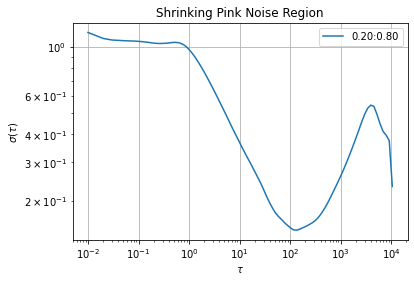

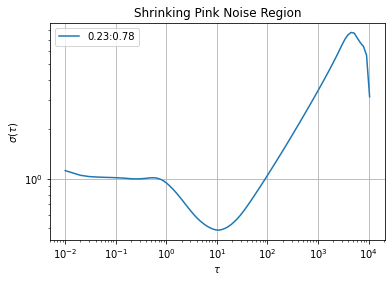

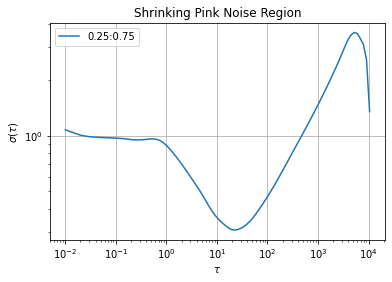

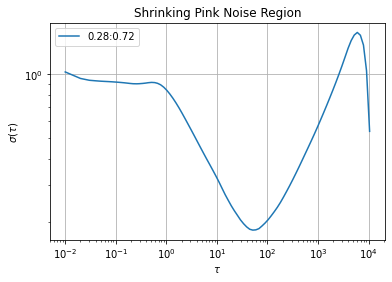

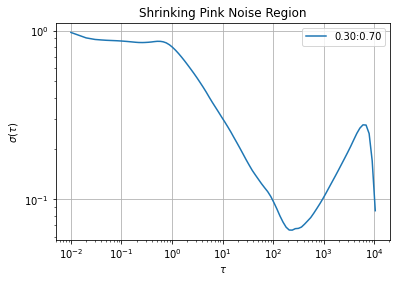

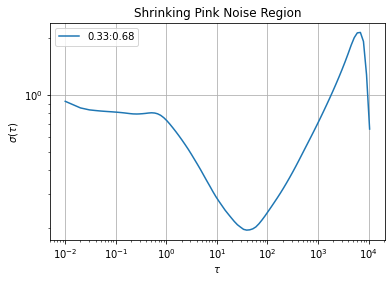

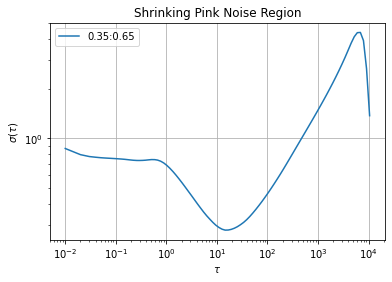

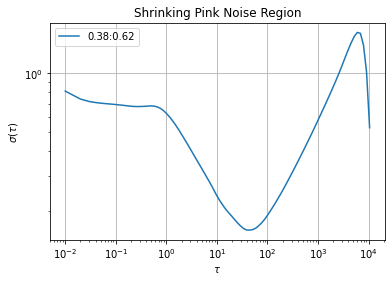

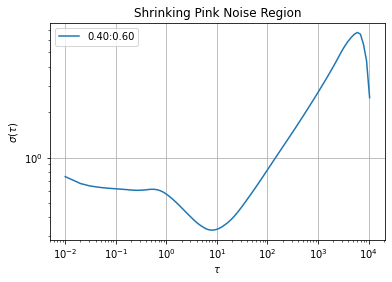

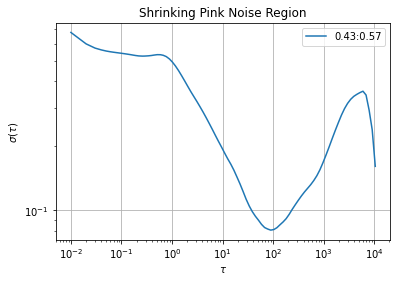

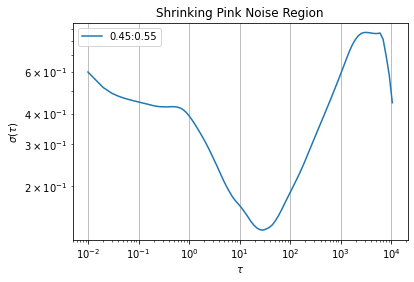

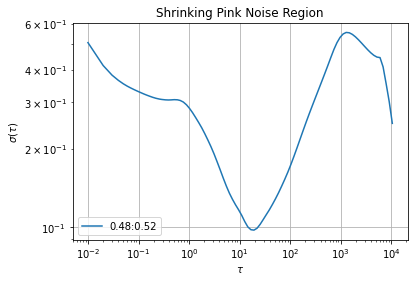

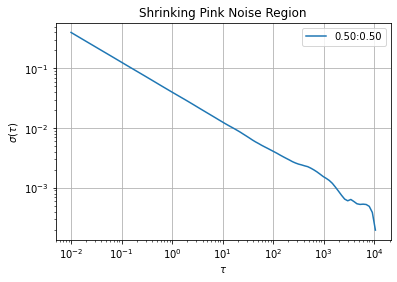

In [38]:
shrinking_pink_noise_region(ideal_stationary+white_noise, regions=regions)

In [64]:
left = np.arange(0, 0.81, 0.1)
regions = [(float(x), 1.0) for x in left]
regions

[(0.0, 1.0),
 (0.1, 1.0),
 (0.2, 1.0),
 (0.30000000000000004, 1.0),
 (0.4, 1.0),
 (0.5, 1.0),
 (0.6000000000000001, 1.0),
 (0.7000000000000001, 1.0),
 (0.8, 1.0)]

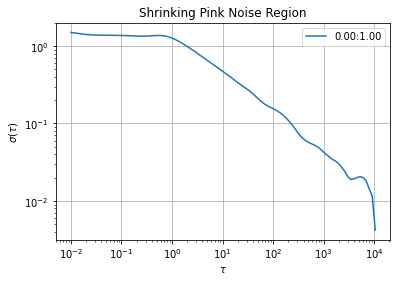

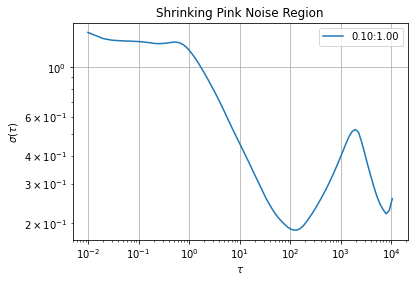

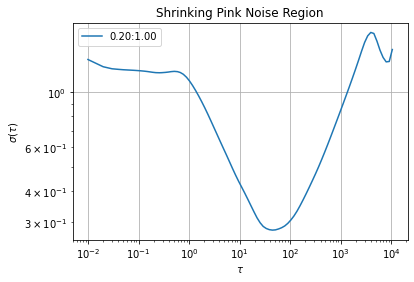

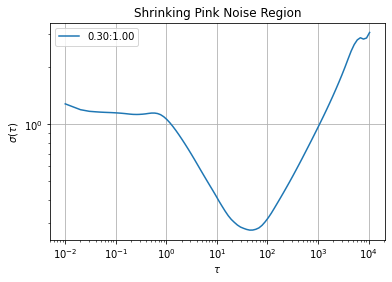

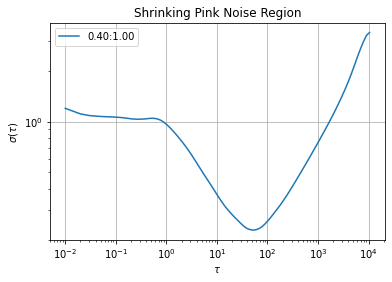

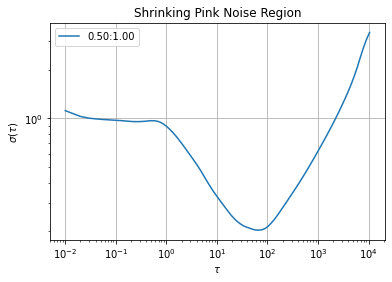

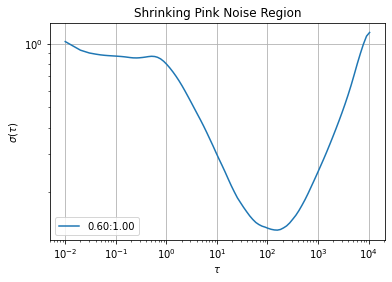

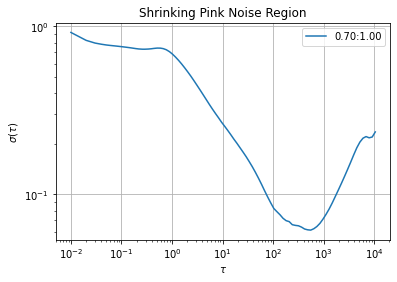

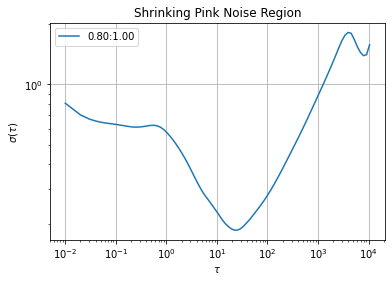

In [65]:
shrinking_pink_noise_region(ideal_stationary+white_noise, regions=regions)

## ADEV on Only Noise Series

$\sigma_{total}^{2} = \sigma_{quant}^{2} + \sigma_{RW}^{2} + \sigma_{Bias}^{2}+...$


In [41]:
#Sampling rate Hz
Fs = 100
#number of points
num_points = 2_500_000

white_noise = allantools.noise.white(num_points=num_points, fs=Fs)
pink_noise = allantools.noise.pink(num_points=num_points)
#pink_noise = position_noise(allantools.noise.pink, white_noise, 0.0, 0.25)
red_noise = allantools.noise.brown(num_points=num_points, fs=Fs)

No handles with labels found to put in legend.


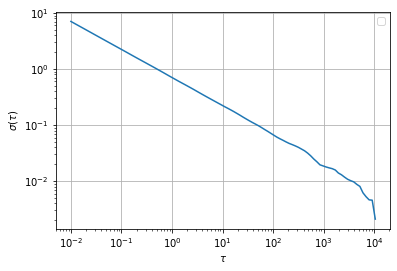

No handles with labels found to put in legend.


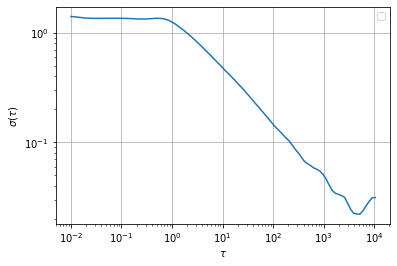

No handles with labels found to put in legend.


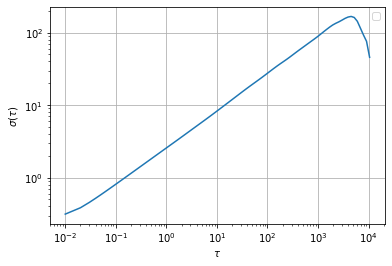

In [42]:
noises = [white_noise, pink_noise, red_noise]
for noise in noises:
    taus, oadev = overlapping_allan_deviation(noise, Fs=Fs)
    plot_allan_deviation(taus, oadev, "", "")

## Appending Pink Noise at the End of the Sequence

In [43]:
portion_white_noise = 0.5
white_noise = position_noise(allantools.noise.white, ideal_stationary, 0.0, portion_white_noise)
pink_noise = position_noise(allantools.noise.pink, ideal_stationary, portion_white_noise, 1.0)

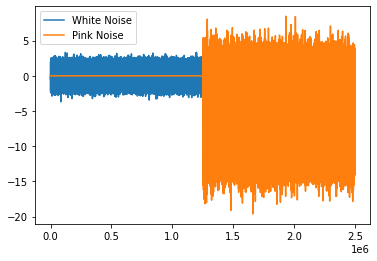

In [44]:
plt.plot(white_noise, label="White Noise")
plt.plot(pink_noise, label="Pink Noise")
plt.legend()

Text(0.5, 0, 'Time (sec)')

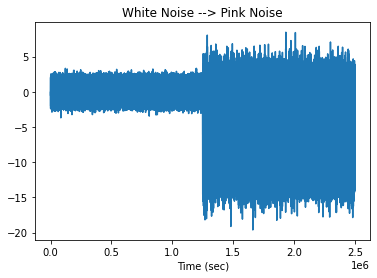

In [60]:
plt.plot(white_noise+pink_noise)
plt.title("White Noise --> Pink Noise")
plt.xlabel("Time (sec)")

In [45]:
taus, oadev = overlapping_allan_deviation(white_noise+pink_noise, 100)

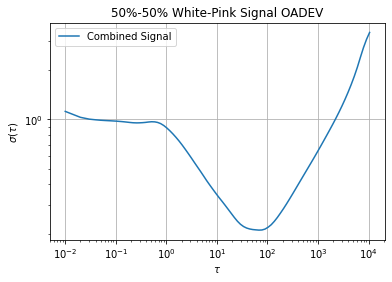

In [46]:
plot_allan_deviation(taus, oadev, "Combined Signal", "50%-50% White-Pink Signal OADEV")

In [47]:
def vary_frequency(frequency):

    signal = white_noise+pink_noise
    taus, oadev = overlapping_allan_deviation(signal, frequency)
    return taus[np.argmin(oadev)]

#vary the frequency and find the tau of MIN(ADEV)
freqs = [10**i for i in range(0, 6)]
mins = [vary_frequency(f) for f in freqs]

Varying the frequency is the same as changing the measurement experiment time.

It's interesting that as you increase the frequency, you have to average for less time to eliminate the high frequency noise.

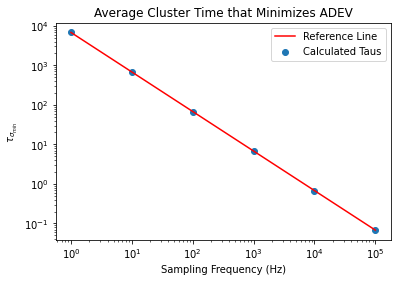

In [48]:
x = np.arange(len(freqs))

fig, ax = plt.subplots()
#mins_bars = ax.bar(x, mins)
mins_values = ax.scatter(freqs, mins, label="Calculated Taus")
ref_values = ax.plot(freqs, np.multiply(mins[0], np.power(freqs, -1.0)), color="red", label="Reference Line")

ax.set_title("Average Cluster Time that Minimizes ADEV")
ax.set_ylabel("$\\tau_{\sigma_{min}}$")
ax.set_xlabel("Sampling Frequency (Hz)")
ax.set_xticks(x)
ax.set_xticklabels(freqs)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(loc="upper right")

plt.show()

## Append Scaled Down Pink Noise to the End of a Series

In [49]:
def vary_portion_of_scaled_pink(p, display=True):
    #generate noise
    white_noise = position_noise(allantools.noise.white, ideal_stationary, 0.0, p)
    pink_noise = position_noise(allantools.noise.pink, ideal_stationary, p, 1.0)
    pink_noise *= 1/5
    #pink_noise += np.mean(white_noise)-np.mean(pink_noise)
    #pink_noise = normalize(pink_noise, np.min(pink_noise), np.max(pink_noise), np.min(white_noise), np.max(white_noise))

    #append pink noise to the end of white noise
    signal = white_noise+pink_noise

    taus, oadev = overlapping_allan_deviation(signal, 100)

    standard_deviations = (oadev[0], np.std(signal))
    if display:
        title_string = "Combined Signal - White Noise Portion {:.2f}\nStandard Deviations = {}".format(p, standard_deviations)

        fig, axs = plt.subplots(2)
        axs[0].plot(signal)
        axs[0].set_title(title_string)

        axs[1].loglog(taus, oadev)
        axs[1].set_title("Overlapping Allan Deviation")

        fig.tight_layout(pad=3.0)
    return taus[np.argmin(oadev)]

In [50]:
vary_portion_of_scaled_pink(0.5, display=False)

89.73

In reality, these represent different measurement experiments with the same sampling frequency. So, it is not useful to compare the OADEV minima

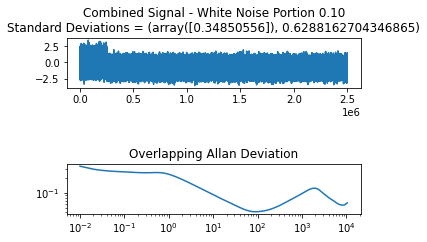

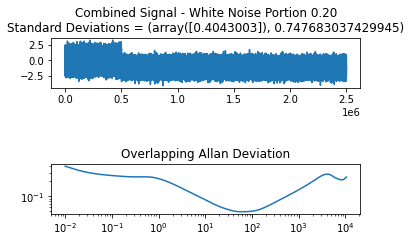

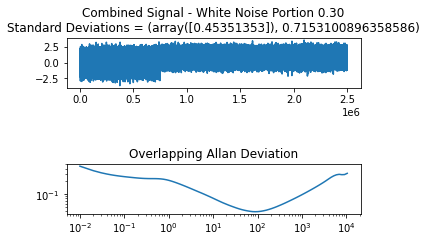

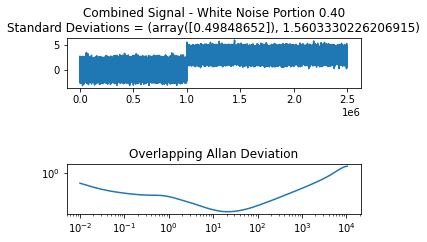

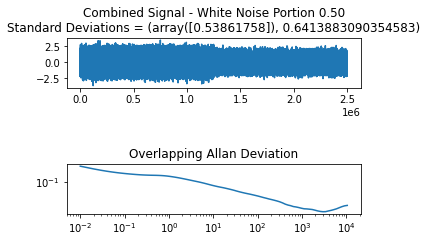

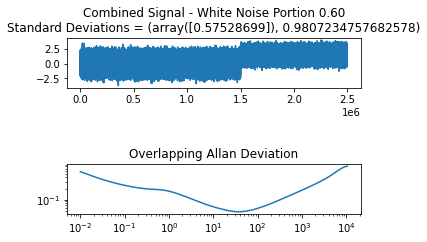

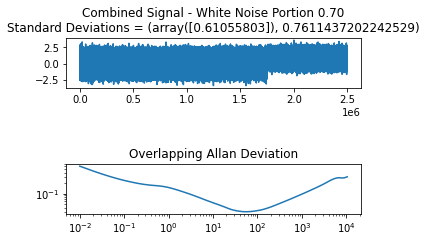

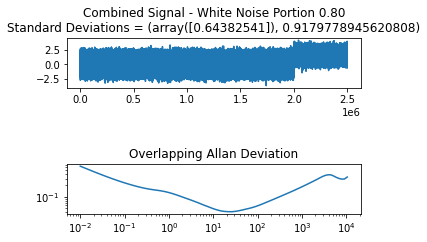

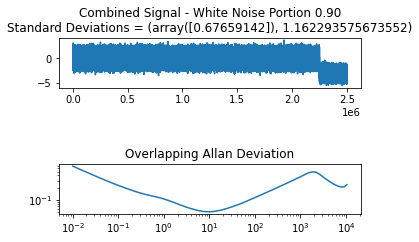

In [51]:
for p in np.arange(0.1, 1, 0.1):
    vary_portion_of_scaled_pink(float(p))

## Distribution of Minimizing $\tau$ Values

In [56]:
chosen_p = 0.7
tau_minimize = [vary_portion_of_scaled_pink(chosen_p, display=False) for i in range(50)]

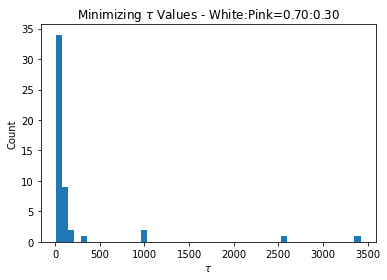

In [57]:
plt.hist(tau_minimize, bins=50)
plt.xlabel("$\\tau$")
plt.ylabel("Count")
plt.title("Minimizing $\\tau$ Values - White:Pink={:.2f}:{:.2f}".format(chosen_p, 1.0-chosen_p));

I don't care much about the outliers, so let's make a more detailed histogram in the most dense part of the domain.

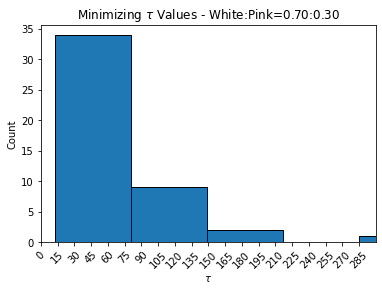

In [58]:
plt.hist(tau_minimize, bins=50, edgecolor="black")
plt.xlabel("$\\tau$")
plt.ylabel("Count")
plt.title("Minimizing $\\tau$ Values - White:Pink={:.2f}:{:.2f}".format(chosen_p, 1.0-chosen_p));

plt.xlim(0, 300)
plt.xticks(np.arange(0, 300, 15), rotation=45);